##  Fashion-MNIST

In this project, we can see the difference in accuracy and validation loss after implementing Dropout regularization to a Neural Network. We will build a Sequential Neural Network from scratch using PyTorch library to classify 10 different classes in the fashion-MNIST dataset. The dataset is a 28x28 greyscale image of clothes. We will dive in into the implementation of dropouts and prove if it will prevent overfitting.

In [123]:
import torch
from torchvision import datasets, transforms
import helper
import numpy as np

In [2]:
from torch import nn
from torch.functional import F
from torch import optim

In [3]:
# Plot the graph here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [64]:
#transform = transforms.Compose([
#                                transforms.ToTensor(), 
#                                transforms.Normalize(
#                                    (0.5, 0.5, 0.5),
#                                    (0.5, 0.5, 0.5)
#                                )
#                               ])

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [74]:
traindataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', 
                                     download=True,
                                     train=True,
                                     transform=transform)

In [75]:
trainloader = torch.utils.data.DataLoader(dataset=traindataset, 
                                          batch_size=64, 
                                          shuffle=True)

In [76]:
testdataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', 
                                    download=True,
                                    train=False,
                                    transform=transform)

In [77]:
testloader = torch.utils.data.DataLoader(dataset=testdataset, 
                                         batch_size=64, 
                                         shuffle=True)

In [78]:
### Define Network without Dropouts
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Create layers here
        self.layer_input      = nn.Linear(784,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_output     = nn.Linear(64,10)
        
    def forward(self, x):
        # Flattened the input to make sure it fits the layer input
        x = x.view(x.shape[0], -1)
        
        # Pass in the input to the layer and do forward propagation
        x = F.relu(self.layer_input(x))
        x = F.relu(self.layer_hidden_one(x))
        x = F.relu(self.layer_hidden_two(x))
        
        # Dimension = 1
        x = F.log_softmax(self.layer_output(x), dim=1)
        
        return x

In [79]:
# Instantiate the model
model = NeuralNetwork()

In [80]:
# Get the images and labels from the test loader
images, labels = next(iter(testloader))

In [81]:
# Get the log probability prediction from our model
log_ps = model(images)

In [82]:
# Normalize the probability by taking the exponent of the log-prob
ps = torch.exp(log_ps)

In [83]:
# Print out the size
print(ps.shape)

torch.Size([64, 10])


In [84]:
top_p, top_class = ps.topk(1,dim=1)

In [85]:
# Print out the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [86]:
# We have to reshape the labels to 64x1 using the view() method
equals = top_class == labels.view(*top_class.shape)

In [87]:
print(equals.shape)

torch.Size([64, 1])


In [88]:
accuracy = torch.mean(equals.type(torch.FloatTensor))

In [89]:
# Print the accuracy
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


In [90]:
# Instantiate the model
model = NeuralNetwork()

In [91]:
# Use Negative Log Likelyhood as our loss function
loss_function = nn.NLLLoss()

In [92]:
# Use ADAM optimizer to utilize momentum
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [93]:
# Train the model 30 cycles
epochs = 30

In [94]:
# Initialize two empty arrays to hold the train and test losses
train_losses, test_losses = [],[]

In [95]:
# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    for images,labels in trainloader:
        optimizer.zero_grad()                      
        log_ps = model(images)                     
        loss = loss_function(log_ps, labels)       
        loss.backward()                            # Backpropagate
        optimizer.step()                           
        running_loss += loss.item()                
    
    # Initialize test loss and accuracy to be 0 
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Loop through all of the validation set
        for images, labels in testloader:
            log_ps = model(images)                                 
            ps = torch.exp(log_ps)                                 
            test_loss += loss_function(log_ps, labels)             
            top_p, top_class = ps.topk(1,dim=1)                    
            equals = top_class == labels.view(*top_class.shape)   
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

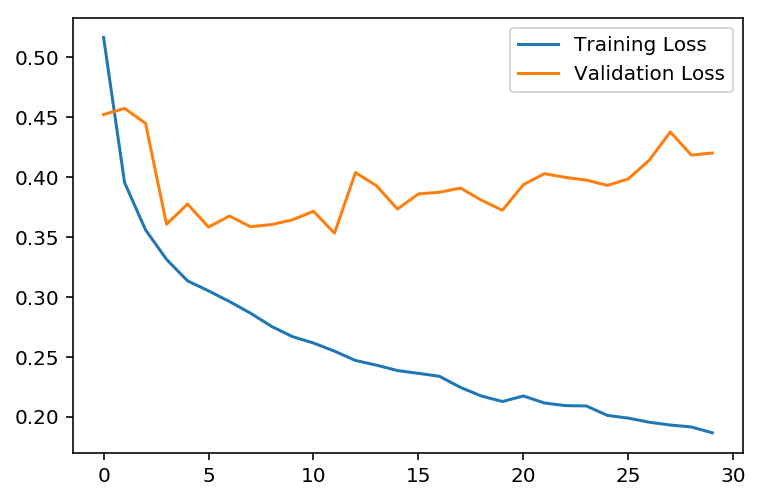

In [96]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses,  label='Validation Loss')
plt.legend(frameon=True)

In [97]:
### Define Network with Dropouts
class NeuralNetworkDropout(nn.Module):
    def __init__(self):
        super().__init__()
        # Create layers here
        self.layer_input      = nn.Linear(784,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_output     = nn.Linear(64,10)
        
        # 20% Dropout here
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        # Flattened the input to make sure it fits the layer input
        x = x.view(x.shape[0],-1)
        
        # Pass in the input to the layer and do forward propagation
        x = self.dropout(F.relu(self.layer_input(x)))
        x = self.dropout(F.relu(self.layer_hidden_one(x)))
        x = self.dropout(F.relu(self.layer_hidden_two(x)))
        
        # Dimension = 1
        x = F.log_softmax(self.layer_output(x),dim=1)
        return x

In [98]:
# Instantiate the model
model = NeuralNetworkDropout()

In [99]:
# Use Negative Log Likelyhood as our loss function
loss_function = nn.NLLLoss()

In [100]:
# Use ADAM optimizer to utilize momentum
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [101]:
# Train the model 30 cycles
epochs = 30

In [102]:
# Initialize two empty arrays to hold the train and test losses
train_losses, test_losses = [],[]

In [103]:
# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    for images,labels in trainloader:
        optimizer.zero_grad()                      
        log_ps = model(images)                     
        loss = loss_function(log_ps, labels)   
        # Backpropagate
        loss.backward()
        optimizer.step()                           
        running_loss += loss.item()                
    
    # Initialize test loss and accuracy to be 0 
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Turn on Evaluation mode
        model.eval()
        # Loop through all of the validation set
        for images, labels in testloader:
            log_ps = model(images)                                 
            ps = torch.exp(log_ps)                                 
            test_loss += loss_function(log_ps, labels)             
            top_p, top_class = ps.topk(1,dim=1)                    
            equals = top_class == labels.view(*top_class.shape)   
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    # Turn on Training mode again
    model.train()
    
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

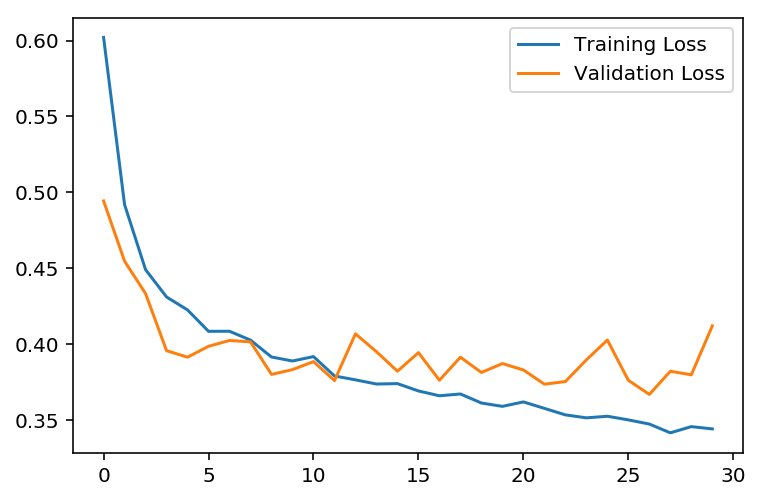

In [104]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)

### Inference

In [105]:
# Make sure to make our model in the evaluation mode
model.eval()

NeuralNetworkDropout(
  (layer_input): Linear(in_features=784, out_features=256, bias=True)
  (layer_hidden_one): Linear(in_features=256, out_features=128, bias=True)
  (layer_hidden_two): Linear(in_features=128, out_features=64, bias=True)
  (layer_output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [106]:
# Get the next image and label
images, labels = next(iter(testloader))
img = images[0]

In [107]:
# Convert 2D image to 1D vector
img = img.view(1, 784)

In [108]:
# Calculate the class probabilities (log-softmax) for img
with torch.no_grad():
    output = model.forward(img)

In [109]:
# Normalize the output
ps = torch.exp(output)

In [121]:
## Visualize the classification of the model
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

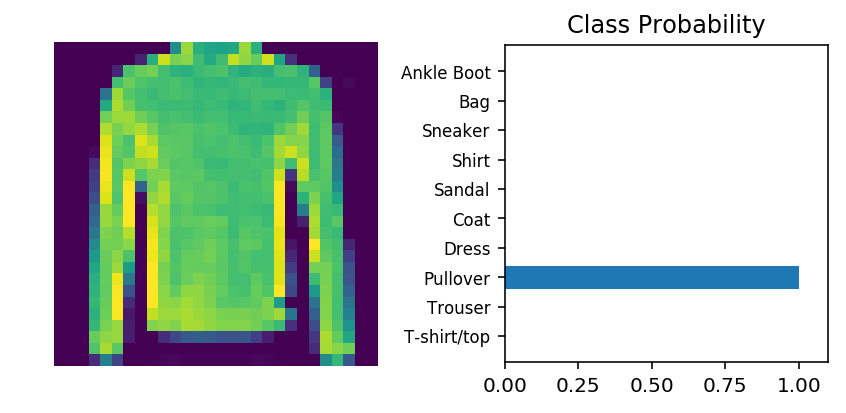

In [122]:
# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')